In [1]:
import numpy as np
import pandas as pd
import h5py
import time
import matplotlib.pyplot as plt
from scipy import ndimage
import matplotlib.gridspec as gridspec

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import lightgbm as lgb

In [2]:
CUBE_PATH = "../sdss_cube_sfr/SDSS_cube_lean.h5"
sfrs = pd.read_hdf(CUBE_PATH, key="fits_spectra_metadata_star_formation_rates")
with h5py.File(CUBE_PATH, "r") as cube:
    metadata = cube["dense_cube/0/ml_spectrum/spec_metadata_refs"][:]
metadata_indices = metadata[:, 0]["ds_slice_idx"]

# Data exploration and processing:

In [3]:
sfrs = sfrs[sfrs.index.isin(metadata_indices)].copy()
sfrs = sfrs[sfrs["AVG"].notna()].copy()
sfrs_filtered = sfrs[sfrs["AVG"] >= -80].copy()
sfrs_flag0_filtered = sfrs_filtered[sfrs_filtered["FLAG"] == 0.0].copy()

print("Total records (before filtering):", len(sfrs))
print("Total records (after filtering AVG >= -80):", len(sfrs_filtered))
print("FLAG == 0 count:", len(sfrs_flag0_filtered))

mask_all = np.in1d(metadata_indices, sfrs_filtered.index)
mask_flag0 = np.in1d(metadata_indices, sfrs_flag0_filtered.index)
selected_all = metadata_indices[mask_all]
selected_flag0 = metadata_indices[mask_flag0]

Total records (before filtering): 34613
Total records (after filtering AVG >= -80): 30752
FLAG == 0 count: 16841


In [4]:
all_images = []
all_spectra = []
filtered_images = []
filtered_spectra = []

for zoom in range(4):
    img_key = f"dense_cube/{zoom}/ml_image/cutout_3d_cube_zoom_{zoom}"
    spec_key = f"dense_cube/{zoom}/ml_spectrum/spectral_1d_cube_zoom_{zoom}"
    with h5py.File(CUBE_PATH, "r") as cube:
        images_zoom = cube[img_key][:][mask_all]
        spectra_zoom = cube[spec_key][:][mask_all]
    all_images.append(images_zoom)
    all_spectra.append(spectra_zoom)
    
    with h5py.File(CUBE_PATH, "r") as cube:
        images_zoom_flag0 = cube[img_key][:][mask_flag0]
        spectra_zoom_flag0 = cube[spec_key][:][mask_flag0]
    filtered_images.append(images_zoom_flag0)
    filtered_spectra.append(spectra_zoom_flag0)

print("All images shape (zoom 0):", all_images[0].shape)
print("Filtered images shape (zoom 0):", filtered_images[0].shape)
print("All spectra shape (zoom 0):", all_spectra[0].shape)
print("Filtered spectra shape (zoom 0):", filtered_spectra[0].shape)

All images shape (zoom 0): (30752, 5, 64, 64)
Filtered images shape (zoom 0): (16841, 5, 64, 64)
All spectra shape (zoom 0): (30752, 4620)
Filtered spectra shape (zoom 0): (16841, 4620)


In [5]:
mask_clean_all = ~np.isnan(all_spectra[0]).any(axis=1)
mask_clean_flag0 = ~np.isnan(filtered_spectra[0]).any(axis=1)

cleaned_all_images = [arr[mask_clean_all] for arr in all_images]
cleaned_all_spectra = [arr[mask_clean_all] for arr in all_spectra]
cleaned_filtered_images = [arr[mask_clean_flag0] for arr in filtered_images]
cleaned_filtered_spectra = [arr[mask_clean_flag0] for arr in filtered_spectra]

selected_all_clean = selected_all[mask_clean_all]
selected_flag0_clean = selected_flag0[mask_clean_flag0]

In [6]:
cleaned_sfrs_all = sfrs_filtered.loc[selected_all_clean]
cleaned_sfrs_flag0 = sfrs_flag0_filtered.loc[selected_flag0_clean]

print("Cleaned All spectra shape (zoom 0):", cleaned_all_spectra[0].shape)
print("Cleaned FLAG==0 spectra shape (zoom 0):", cleaned_filtered_spectra[0].shape)

Cleaned All spectra shape (zoom 0): (20157, 4620)
Cleaned FLAG==0 spectra shape (zoom 0): (11179, 4620)


In [7]:
def normalize_images(images_list):
    normalized_list = []
    for img_array in images_list:
        min_val = np.min(img_array, axis=(2,3), keepdims=True)
        max_val = np.max(img_array, axis=(2,3), keepdims=True)
        norm_img = 2 * (img_array - min_val) / (max_val - min_val) - 1
        normalized_list.append(norm_img)
    return normalized_list

normalized_all_images = normalize_images(cleaned_all_images)
normalized_filtered_images = normalize_images(cleaned_filtered_images)

def normalize_spectra(spectra_list):
    normalized_list = []
    for spec in spectra_list:
        if spec.ndim == 1:
            spec = spec[np.newaxis, :]
        min_val = np.nanmin(spec, axis=1, keepdims=True)
        max_val = np.nanmax(spec, axis=1, keepdims=True)
        diff = np.where((max_val - min_val)==0, 1, max_val - min_val)
        norm_spec = 2 * (spec - min_val) / diff - 1
        normalized_list.append(norm_spec)
    return normalized_list

normalized_all_spectra = normalize_spectra(cleaned_all_spectra)
normalized_filtered_spectra = normalize_spectra(cleaned_filtered_spectra)

FLAG == 0 (Original): Found 1111 images with multiple objects from 11179 (9.94%).


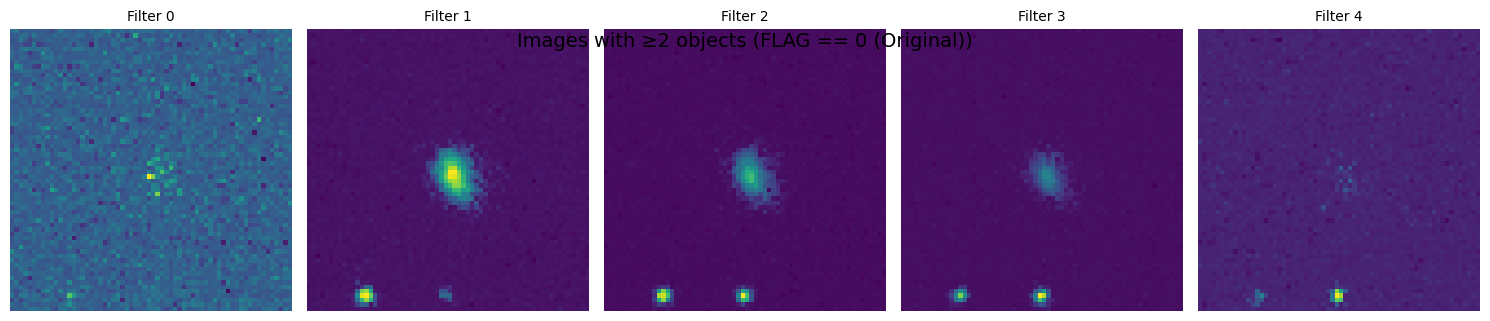

In [8]:
selected_Y_flag0 = cleaned_sfrs_flag0.loc[selected_flag0_clean]["AVG"].values

CROP_SIZES_4 = {0: 32, 1: 16, 2: 8, 3: 4} 
THRESHOLD = 0.9

def detect_and_visualize_multiple_objects(images_list, thresholds, crop_sizes=None, max_objects=1, thumbnail_size=3, group_name="", print_spectra=False, spectra_list=None):
    images_trimmed = []
    for i, img_array in enumerate(images_list):
        original_size = img_array.shape[-1]
        target_size = crop_sizes.get(i, original_size) if crop_sizes is not None else original_size
        start = (original_size - target_size) // 2
        end = start + target_size
        trimmed = img_array[..., start:end, start:end]
        images_trimmed.append(trimmed)
    multi_obj_indices = []
    for idx in range(images_trimmed[0].shape[0]):
        image = images_trimmed[0][idx, 2, :, :]
        image_normalized = (image + 1) / 2
        binary = image_normalized > thresholds
        labeled, num_features = ndimage.label(binary)
        if num_features > 1:
            multi_obj_indices.append(idx)
    total_images = images_trimmed[0].shape[0]
    count_multi = len(multi_obj_indices)
    percent_multi = (count_multi / total_images)*100 if total_images>0 else 0
    print(f"{group_name}: Found {count_multi} images with multiple objects from {total_images} ({percent_multi:.2f}%).")
    if multi_obj_indices:
        display_indices = multi_obj_indices[:max_objects]
        if print_spectra and spectra_list is not None:
            num_disp = len(display_indices)
            fig = plt.figure(figsize=(15, thumbnail_size * 2 * num_disp), dpi=100)
            gs = gridspec.GridSpec(2 * num_disp, 5, hspace=0.6, wspace=0.3)
            for i, obj_idx in enumerate(display_indices):
                for col in range(5):
                    ax = fig.add_subplot(gs[2*i, col])
                    img_data = images_trimmed[0][obj_idx, col, :, :]
                    ax.imshow(img_data, vmin=-1, vmax=1)
                    ax.set_title(f"Filter {col}", fontsize=10)
                    ax.axis("off")
                ax_spec = fig.add_subplot(gs[2*i+1, :])
                spectrum = spectra_list[0][obj_idx]
                wavelengths = np.linspace(3800,9200, len(spectrum))
                ax_spec.plot(wavelengths, spectrum, linewidth=0.3)
                ax_spec.set_title("Spectrum (Zoom 0)", fontsize=10)
                ax_spec.set_xlabel("Wavelength (Å)", fontsize=10)
                ax_spec.set_ylabel("Flux", fontsize=10)
                ax_spec.set_xlim([3800,9200])
                ax_spec.set_ylim([-1,1])
            fig.suptitle(f"Images with ≥2 objects and spectra ({group_name})", fontsize=14)
            fig.tight_layout()
            fig.subplots_adjust(top=0.93)
            plt.show()
        else:
            num_disp = len(display_indices)
            fig, axes = plt.subplots(num_disp, 5, figsize=(15, thumbnail_size * num_disp), dpi=100)
            if num_disp == 1:
                axes = axes.reshape(1, -1)
            for row, obj_idx in enumerate(display_indices):
                for col in range(5):
                    ax = axes[row, col]
                    img_data = images_trimmed[0][obj_idx, col, :, :]
                    ax.imshow(img_data, vmin=-1, vmax=1)
                    ax.set_title(f"Filter {col}", fontsize=10)
                    ax.axis("off")
            fig.suptitle(f"Images with ≥2 objects ({group_name})", fontsize=14)
            fig.tight_layout()
            fig.subplots_adjust(top=0.99)
            plt.show()
    else:
        print(f"No images found for {group_name} with multiple objects.")
    return images_trimmed, multi_obj_indices

orig_images_flag0, multi_obj_indices_flag0 = detect_and_visualize_multiple_objects(
    normalized_filtered_images, thresholds=THRESHOLD, crop_sizes=None,
    group_name="FLAG == 0 (Original)", print_spectra=False, spectra_list=normalized_filtered_spectra
)

In [9]:
X_photo_all = orig_images_flag0[0]        
X_spec_all = normalized_filtered_spectra[2]  
mask_good = np.ones(X_photo_all.shape[0], dtype=bool)
mask_good[multi_obj_indices_flag0] = False

X_photo = X_photo_all[mask_good]
X_spec = X_spec_all[mask_good]
Y = selected_Y_flag0[:X_photo_all.shape[0]][mask_good]

n_samples = min(X_photo.shape[0], X_spec.shape[0], len(Y))
X_photo = X_photo[:n_samples]
X_spec = X_spec[:n_samples]
Y = Y[:n_samples]

In [10]:
X_photo_train_val, X_photo_test, X_spec_train_val, X_spec_test, Y_train_val, Y_test = train_test_split(
    X_photo, X_spec, Y, test_size=0.2, random_state=42
)
X_photo_train, X_photo_val, X_spec_train, X_spec_val, Y_train, Y_val = train_test_split(
    X_photo_train_val, X_spec_train_val, Y_train_val, test_size=0.25, random_state=42
)

print("Train samples:", X_photo_train.shape[0])
print("Validation samples:", X_photo_val.shape[0])
print("Test samples:", X_photo_test.shape[0])

Train samples: 6040
Validation samples: 2014
Test samples: 2014


# Machine Learning (FLAG == 0 only):

In [11]:
def run_grid_search_lgb(X_train, Y_train, X_val, Y_val, param_grid, plot_training_curves=False):
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)

    val_metrics = {
        'learning_rate': [],
        'max_depth': [],
        'r2': [],
        'mae': [],
        'rmse': [],
        'nmad': []
    }

    best_model = None
    best_params = None
    best_score = -np.inf
    best_eval_result = None
    best_iteration = None

    for max_depth in param_grid['max_depth']:
        for lr in param_grid['learning_rate']:
            model = lgb.LGBMRegressor(
                learning_rate=lr,
                max_depth=max_depth,
                random_state=42,
                n_estimators=1000
            )

            model.fit(
                X_train_flat, Y_train,
                eval_set=[(X_train_flat, Y_train), (X_val_flat, Y_val)],
                eval_metric="rmse",
                callbacks=[lgb.early_stopping(10), lgb.log_evaluation(0)]
            )

            y_val_pred = model.predict(X_val_flat, num_iteration=model.best_iteration_)
            r2 = r2_score(Y_val, y_val_pred)
            mae = mean_absolute_error(Y_val, y_val_pred)
            rmse = np.sqrt(mean_squared_error(Y_val, y_val_pred))
            error = y_val_pred - Y_val
            nmad = 1.4826 * np.median(np.abs(error - np.median(error)))

            val_metrics['learning_rate'].append(lr)
            val_metrics['max_depth'].append(max_depth)
            val_metrics['r2'].append(r2)
            val_metrics['mae'].append(mae)
            val_metrics['rmse'].append(rmse)
            val_metrics['nmad'].append(nmad)

            if r2 > best_score:
                best_score = r2
                best_model = model
                best_params = {'learning_rate': lr, 'max_depth': max_depth}
                best_eval_result = model.evals_result_
                best_iteration = model.best_iteration_

    if plot_training_curves and best_eval_result is not None:
        train_rmse = best_eval_result['training']['rmse']
        valid_rmse = best_eval_result['valid_1']['rmse']
        epochs = len(train_rmse)
        x_axis = range(epochs)

        plt.figure(figsize=(10, 6))
        plt.plot(x_axis, train_rmse, label='Train RMSE')
        plt.plot(x_axis, valid_rmse, label='Validation RMSE')
        plt.axvline(best_iteration, color='red', linestyle='--', label=f'Best Iteration ({best_iteration})')
        plt.xlabel("Iteration")
        plt.ylabel("RMSE")
        plt.title("Best Model Training and Validation Loss (RMSE)")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return best_score, best_params, val_metrics, best_model

def visualize_lgb_results(metrics_dict, title):
    import seaborn as sns
    import pandas as pd

    df = pd.DataFrame(metrics_dict)
    metrics = ['r2', 'mae', 'rmse', 'nmad']
    colors = ['r', 'b', 'g', 'orange', 'purple', 'brown']

    plt.figure(figsize=(16, 12))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i + 1)
        for i, depth in enumerate(sorted(df['max_depth'].unique())):
            subset = df[df['max_depth'] == depth]
            plt.plot(subset['learning_rate'], subset[metric], marker='o', label=f"max_depth={depth}", color=colors[i % len(colors)])
        plt.xlabel("Learning Rate")
        plt.ylabel(metric.upper())
        plt.title(f"{title} - {metric.upper()} vs Learning Rate")
        plt.legend()

    plt.tight_layout()
    plt.show()

param_grid_lgb = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001]
}

runtime = {}

# LGBM

### LGBM on Photo:

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.596531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 6040, number of used features: 20480
[LightGBM] [Info] Start training from score -0.170056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.622543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 6040, number of used features: 20480
[LightGBM] [Info] Start training from score -0.170056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.833975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 6040, number of used features: 20480
[LightGBM] [Info] Start training from score -0.170056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.848872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 6040, number of used features: 20480
[LightGBM] [Info] Start training from score -0.170056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.665650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 6040, number of used features: 20480
[LightGBM] [Info] Start training from score -0.170056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.843839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 6040, number of used features: 20480
[LightGBM] [Info] Start training from score -0.170056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.823683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 6040, number of used features: 20480
[LightGBM] [Info] Start training from score -0.170056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.809587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 6040, number of used features: 20480
[LightGBM] [Info] Start training from score -0.170056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.639972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5222400
[LightGBM] [Info] Number of data points in the train set: 6040, number of used features: 20480
[LightGBM] [Info] Start training from score -0.170056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


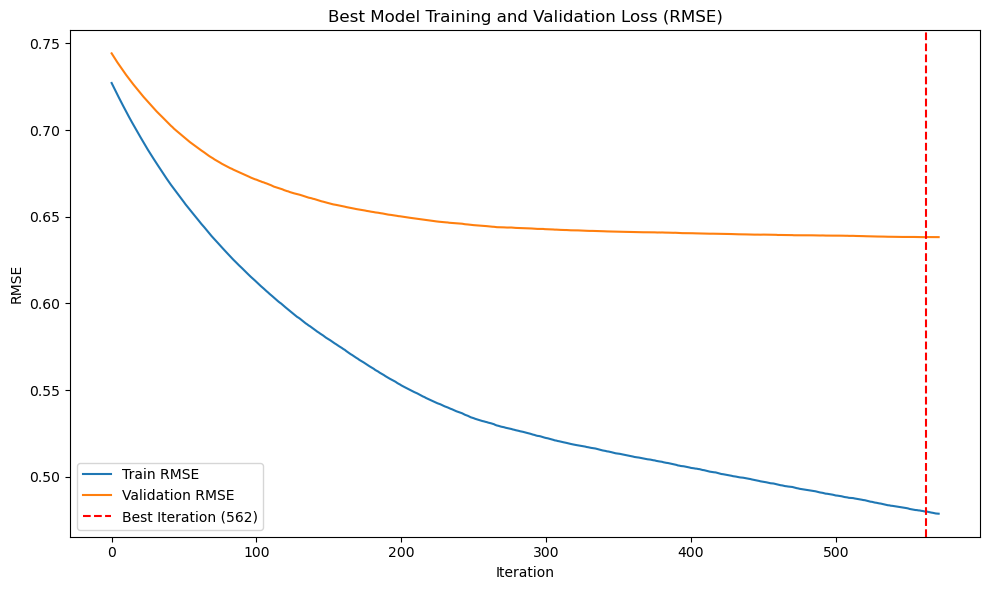

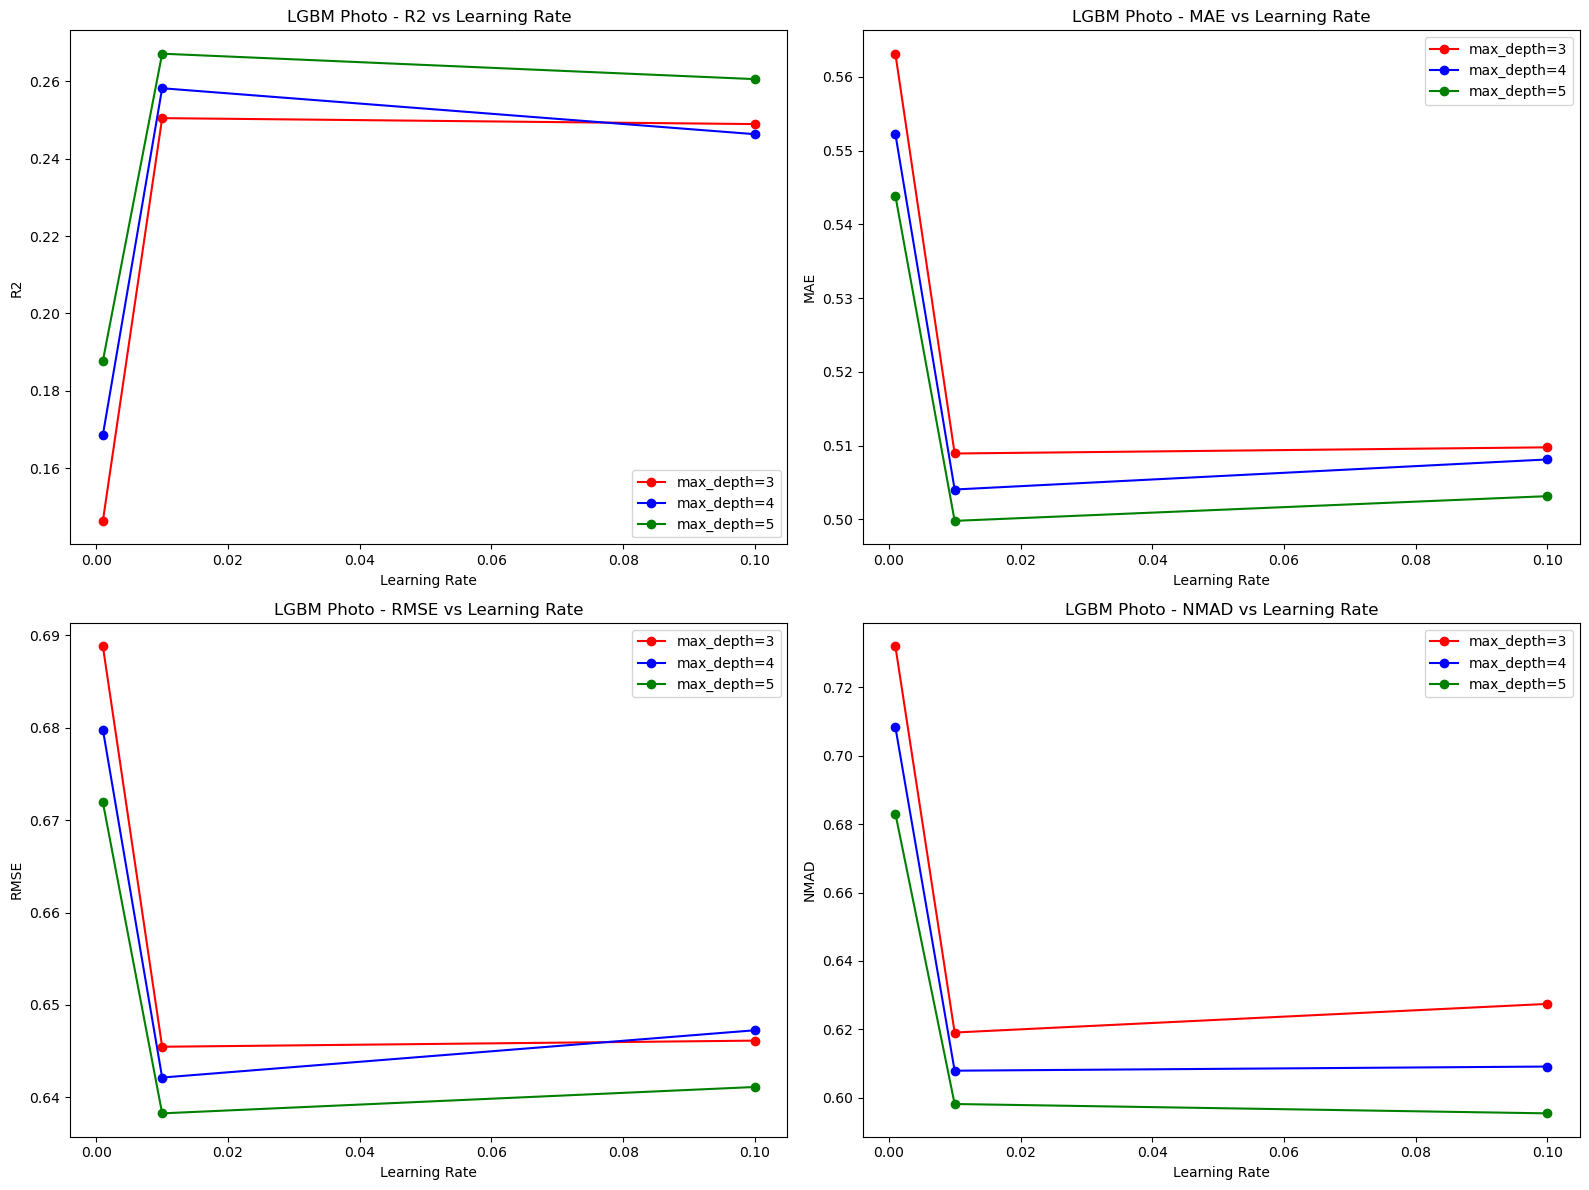

Best LGBM Photo params: {'learning_rate': 0.01, 'max_depth': 5}


In [12]:
start = time.time()
lgb_photo_score, lgb_photo_params, lgb_photo_metrics, lgb_photo_model = run_grid_search_lgb(
    X_photo_train, Y_train, X_photo_val, Y_val, param_grid_lgb, plot_training_curves=True
)
runtime["LGBM Photo"] = time.time() - start
visualize_lgb_results(lgb_photo_metrics, "LGBM Photo")
print("Best LGBM Photo params:", lgb_photo_params)

### LGBM on Spectra:

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 294515
[LightGBM] [Info] Number of data points in the train set: 6040, number of used features: 1155
[LightGBM] [Info] Start training from score -0.170056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 294515
[LightGBM] [Info] Number of data points in the train set: 6040, number of used features: 1155
[LightGBM] [Info] Start training from score -0.170056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 294515
[LightGBM] [Info] Number of data points in the train set: 6040, number of used features: 1155
[LightGBM] [Info] Start training from score -0.170056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 294515
[LightGBM] [Info] Number of data points in the train set: 6040, number of used features: 1155
[LightGBM] [Info] Start training from score -0.170056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 294515
[LightGBM] [Info] Number of data points in the train set: 6040, number of used features: 1155
[LightGBM] [Info] Start training from score -0.170056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 294515
[LightGBM] [Info] Number of data points in the train set: 6040, number of used features: 1155
[LightGBM] [Info] Start training from score -0.170056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 294515
[LightGBM] [Info] Number of data points in the train set: 6040, number of used features: 1155
[LightGBM] [Info] Start training from score -0.170056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 294515
[LightGBM] [Info] Number of data points in the train set: 6040, number of used features: 1155
[LightGBM] [Info] Start training from score -0.170056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 294515
[LightGBM] [Info] Number of data points in the train set: 6040, number of used features: 1155
[LightGBM] [Info] Start training from score -0.170056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


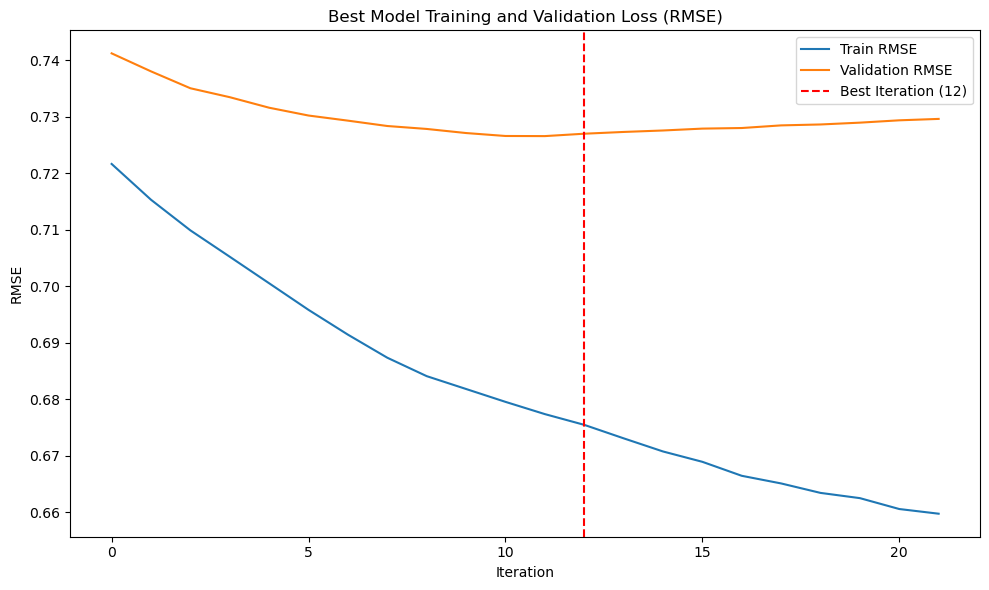

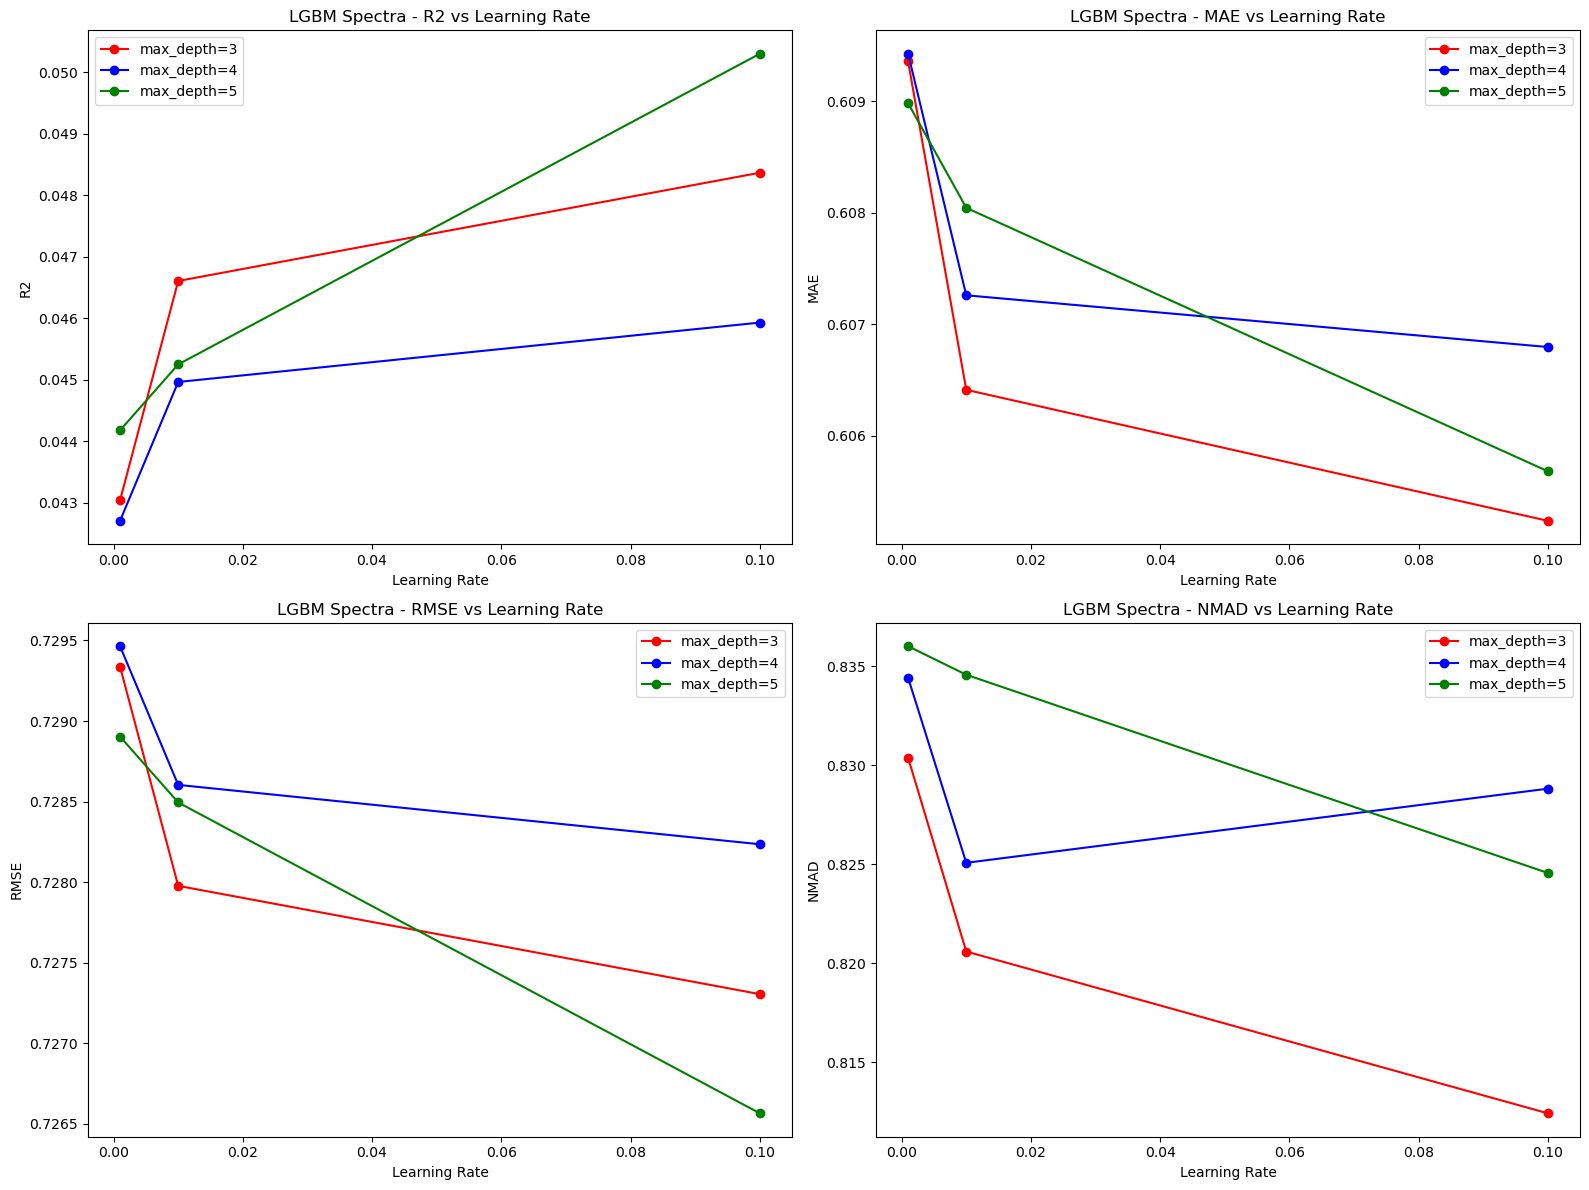

Best LGBM Spectra params: {'learning_rate': 0.1, 'max_depth': 5}


In [13]:
start = time.time()
lgb_spec_score, lgb_spec_params, lgb_spec_metrics, lgb_spec_model = run_grid_search_lgb(
    X_spec_train, Y_train, X_spec_val, Y_val, param_grid_lgb, plot_training_curves=True
)
runtime["LGBM Spectra"] = time.time() - start
visualize_lgb_results(lgb_spec_metrics, "LGBM Spectra")
print("Best LGBM Spectra params:", lgb_spec_params)

### LGBM Early Fusion:

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.863241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5516915
[LightGBM] [Info] Number of data points in the train set: 6040, number of used features: 21635
[LightGBM] [Info] Start training from score -0.170056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.938818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5516915
[LightGBM] [Info] Number of data points in the train set: 6040, number of used features: 21635
[LightGBM] [Info] Start training from score -0.170056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.793812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5516915
[LightGBM] [Info] Number of data points in the train set: 6040, number of used features: 21635
[LightGBM] [Info] Start training from score -0.170056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.912362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5516915
[LightGBM] [Info] Number of data points in the train set: 6040, number of used features: 21635
[LightGBM] [Info] Start training from score -0.170056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.952070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5516915
[LightGBM] [Info] Number of data points in the train set: 6040, number of used features: 21635
[LightGBM] [Info] Start training from score -0.170056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.931360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5516915
[LightGBM] [Info] Number of data points in the train set: 6040, number of used features: 21635
[LightGBM] [Info] Start training from score -0.170056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.831199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5516915
[LightGBM] [Info] Number of data points in the train set: 6040, number of used features: 21635
[LightGBM] [Info] Start training from score -0.170056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.825792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5516915
[LightGBM] [Info] Number of data points in the train set: 6040, number of used features: 21635
[LightGBM] [Info] Start training from score -0.170056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.745113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5516915
[LightGBM] [Info] Number of data points in the train set: 6040, number of used features: 21635
[LightGBM] [Info] Start training from score -0.170056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


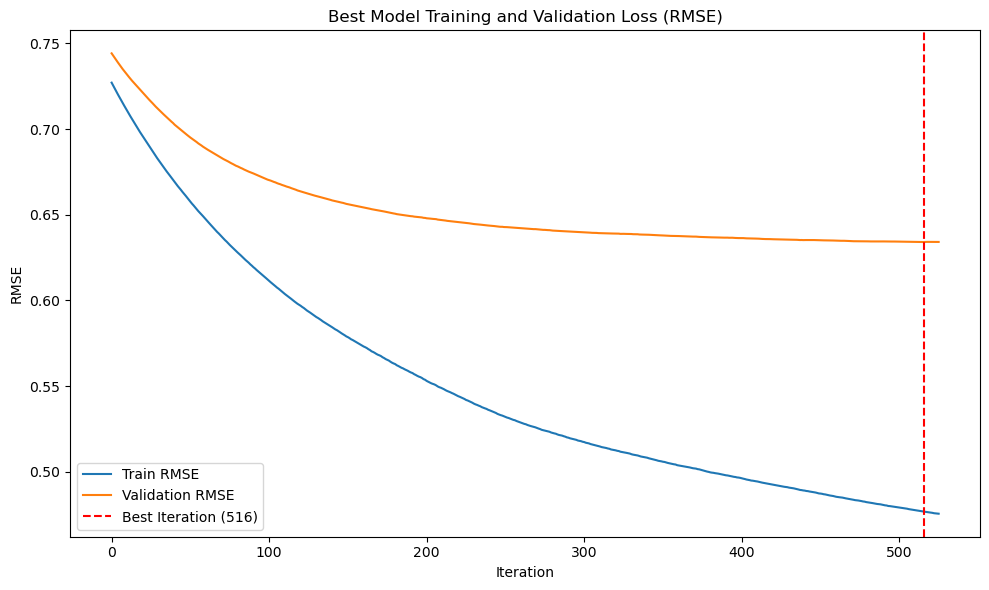

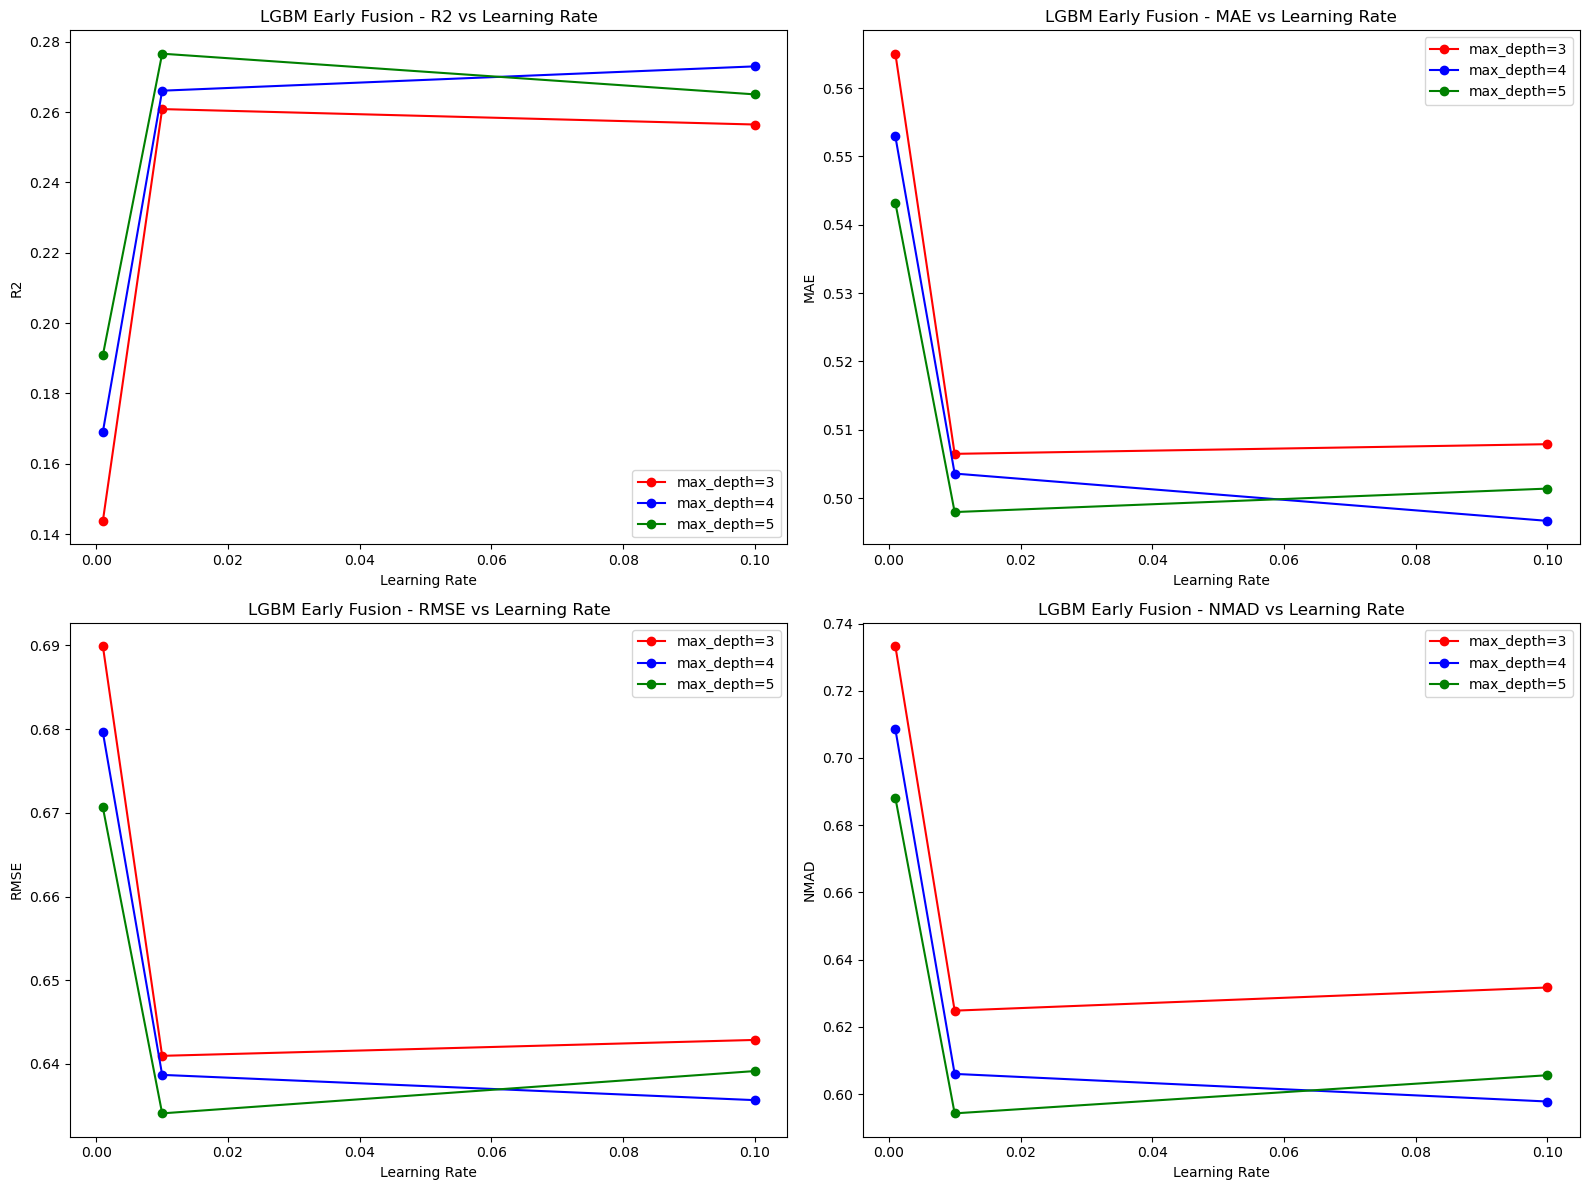

Best LGBM Early Fusion params: {'learning_rate': 0.01, 'max_depth': 5}


In [14]:
X_photo_train_flat = X_photo_train.reshape(X_photo_train.shape[0], -1)
X_spec_train_flat = X_spec_train.reshape(X_spec_train.shape[0], -1)
X_photo_val_flat = X_photo_val.reshape(X_photo_val.shape[0], -1)
X_spec_val_flat = X_spec_val.reshape(X_spec_val.shape[0], -1)

X_early_train = np.concatenate([X_photo_train_flat, X_spec_train_flat], axis=1)
X_early_val = np.concatenate([X_photo_val_flat, X_spec_val_flat], axis=1)

start = time.time()
lgb_early_score, lgb_early_params, lgb_early_metrics, lgb_early_model = run_grid_search_lgb(
    X_early_train, Y_train, X_early_val, Y_val, param_grid_lgb, plot_training_curves=True
)
runtime["LGBM Early Fusion"] = time.time() - start
visualize_lgb_results(lgb_early_metrics, "LGBM Early Fusion")
print("Best LGBM Early Fusion params:", lgb_early_params)

### LGBM Late Fusion:

In [15]:
start = time.time()
X_photo_test_flat = X_photo_test.reshape(X_photo_test.shape[0], -1)
X_spec_test_flat = X_spec_test.reshape(X_spec_test.shape[0], -1)
Y_pred_lgb_photo_test = lgb_photo_model.predict(X_photo_test_flat)
Y_pred_lgb_spec_test = lgb_spec_model.predict(X_spec_test_flat)
Y_pred_lgb_late_test = (Y_pred_lgb_photo_test + Y_pred_lgb_spec_test) / 2.0

lgb_late_mae = mean_absolute_error(Y_test, Y_pred_lgb_late_test)
lgb_late_r2 = r2_score(Y_test, Y_pred_lgb_late_test)
error_late = Y_pred_lgb_late_test - Y_test
lgb_late_nmad = 1.4826 * np.median(np.abs(error_late - np.median(error_late)))
lgb_late_rmse = np.sqrt(mean_squared_error(Y_test, Y_pred_lgb_late_test))
runtime["LGBM Late Fusion"] = time.time() - start + runtime["LGBM Spectra"] + runtime["LGBM Photo"]

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


### Compile all results:

In [16]:
Y_pred_photo_test = lgb_photo_model.predict(X_photo_test_flat)
lgb_photo_mae_test = mean_absolute_error(Y_test, Y_pred_photo_test)
lgb_photo_r2_test = r2_score(Y_test, Y_pred_photo_test)
lgb_photo_error_test = Y_pred_photo_test - Y_test
lgb_photo_nmad_test = 1.4826 * np.median(np.abs(lgb_photo_error_test - np.median(lgb_photo_error_test)))
lgb_photo_rmse_test = np.sqrt(mean_squared_error(Y_test, Y_pred_photo_test))

Y_pred_spec_test = lgb_spec_model.predict(X_spec_test_flat)
lgb_spec_mae_test = mean_absolute_error(Y_test, Y_pred_spec_test)
lgb_spec_r2_test = r2_score(Y_test, Y_pred_spec_test)
lgb_spec_error_test = Y_pred_spec_test - Y_test
lgb_spec_nmad_test = 1.4826 * np.median(np.abs(lgb_spec_error_test - np.median(lgb_spec_error_test)))
lgb_spec_rmse_test = np.sqrt(mean_squared_error(Y_test, Y_pred_spec_test))

X_early_test = np.concatenate([X_photo_test_flat, X_spec_test_flat], axis=1)
Y_pred_early_test = lgb_early_model.predict(X_early_test)
lgb_early_mae_test = mean_absolute_error(Y_test, Y_pred_early_test)
lgb_early_r2_test = r2_score(Y_test, Y_pred_early_test)
lgb_early_error_test = Y_pred_early_test - Y_test
lgb_early_nmad_test = 1.4826 * np.median(np.abs(lgb_early_error_test - np.median(lgb_early_error_test)))
lgb_early_rmse_test = np.sqrt(mean_squared_error(Y_test, Y_pred_early_test))

Y_pred_late_test = (Y_pred_photo_test + Y_pred_spec_test) / 2.0
lgb_late_mae_test = mean_absolute_error(Y_test, Y_pred_late_test)
lgb_late_r2_test = r2_score(Y_test, Y_pred_late_test)
lgb_late_error_test = Y_pred_late_test - Y_test
lgb_late_nmad_test = 1.4826 * np.median(np.abs(lgb_late_error_test - np.median(lgb_late_error_test)))
lgb_late_rmse_test = np.sqrt(mean_squared_error(Y_test, Y_pred_late_test))

comparison = {
    "LGBM Photo": {
        'r2': lgb_photo_r2_test,
        'mae': lgb_photo_mae_test,
        'nmad': lgb_photo_nmad_test,
        'rmse': lgb_photo_rmse_test
    },
    "LGBM Spectra": {
        'r2': lgb_spec_r2_test,
        'mae': lgb_spec_mae_test,
        'nmad': lgb_spec_nmad_test,
        'rmse': lgb_spec_rmse_test
    },
    "LGBM Early Fusion": {
        'r2': lgb_early_r2_test,
        'mae': lgb_early_mae_test,
        'nmad': lgb_early_nmad_test,
        'rmse': lgb_early_rmse_test
    },
    "LGBM Late Fusion": {
        'r2': lgb_late_r2_test,
        'mae': lgb_late_mae_test,
        'nmad': lgb_late_nmad_test,
        'rmse': lgb_late_rmse_test
    }
}

for method, met in comparison.items():
    print(f"{method}: R² = {met['r2']:.3f}, MAE = {met['mae']:.3f}, NMAD = {met['nmad']:.3f}, RMSE = {met['rmse']:.3f}")

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LGBM Photo: R² = 0.291, MAE = 0.472, NMAD = 0.572, RMSE = 0.607
LGBM Spectra: R² = 0.048, MAE = 0.582, NMAD = 0.792, RMSE = 0.703
LGBM Early Fusion: R² = 0.295, MAE = 0.471, NMAD = 0.579, RMSE = 0.605
LGBM Late Fusion: R² = 0.224, MAE = 0.512, NMAD = 0.663, RMSE = 0.634


### Visualization of comparative metrics:

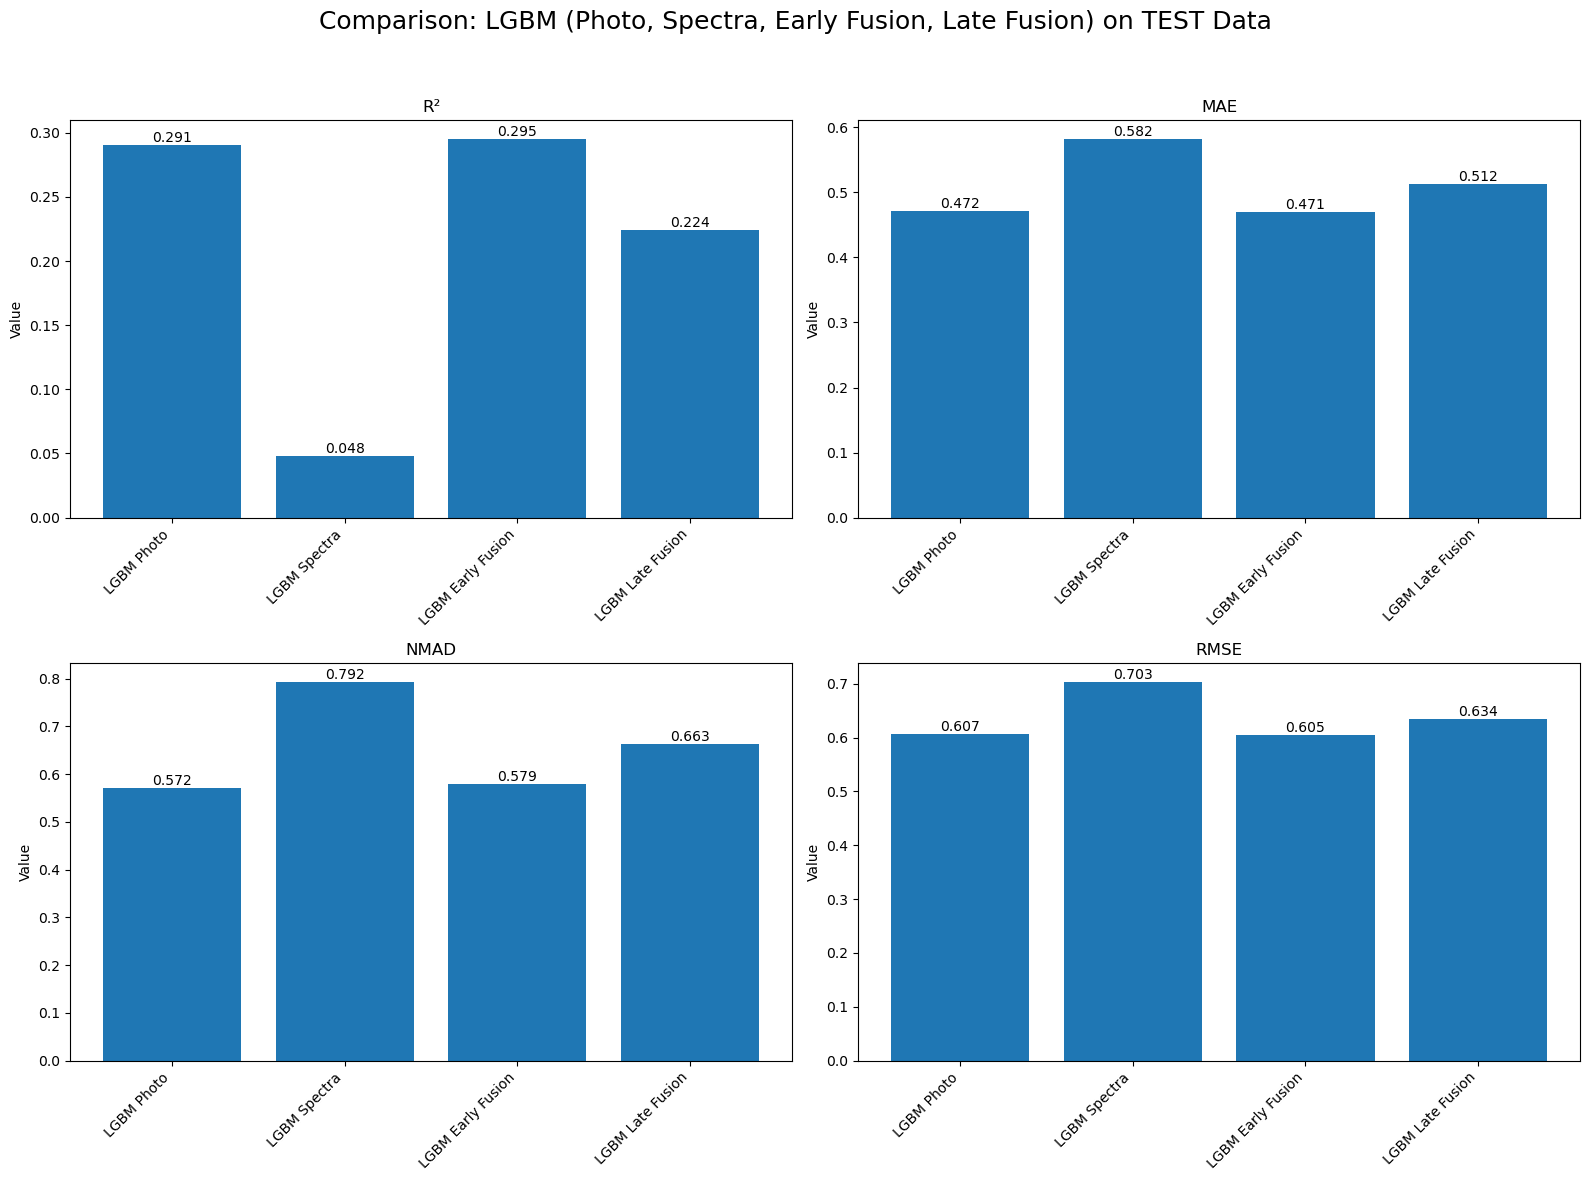

In [17]:
methods = list(comparison.keys())
metrics_names = ['R²', 'MAE', 'NMAD', 'RMSE']
values = {metric: [] for metric in metrics_names}
for method in methods:
    values['R²'].append(comparison[method]['r2'])
    values['MAE'].append(comparison[method]['mae'])
    values['NMAD'].append(comparison[method]['nmad'])
    values['RMSE'].append(comparison[method]['rmse'])

x = np.arange(len(methods))
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.flatten()
for i, metric in enumerate(metrics_names):
    axs[i].bar(x, values[metric])
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(methods, rotation=45, ha='right')
    axs[i].set_title(metric)
    axs[i].set_ylabel("Value")
    for j, v in enumerate(values[metric]):
        axs[i].text(j, v, f"{v:.3f}", ha='center', va='bottom', fontsize=10)
plt.suptitle("Comparison: LGBM (Photo, Spectra, Early Fusion, Late Fusion) on TEST Data", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Visualization of runtimes:

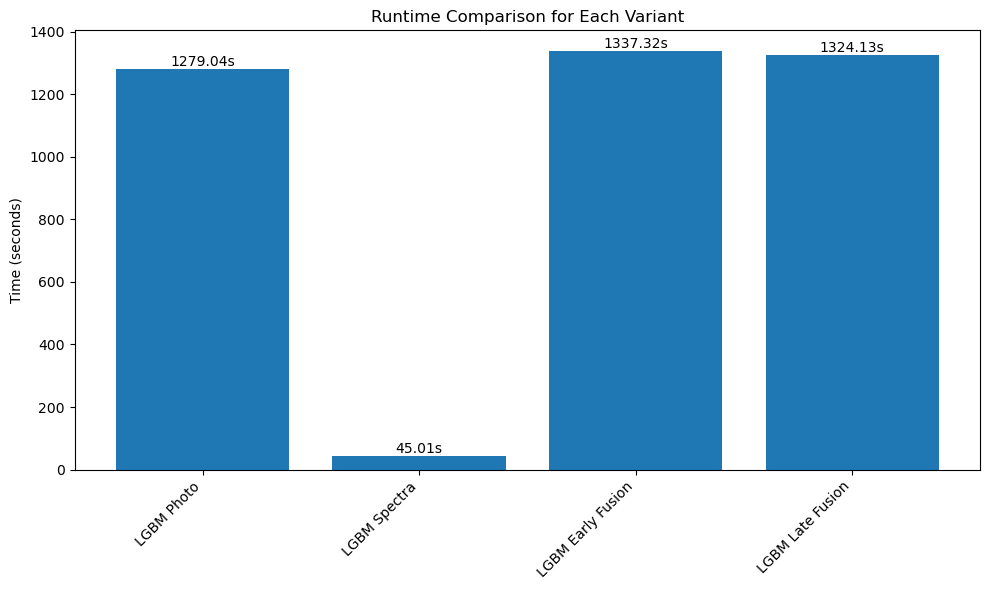

In [18]:
runtime_methods = list(runtime.keys())
runtime_values = [runtime[m] for m in runtime_methods]
plt.figure(figsize=(10, 6))
plt.bar(runtime_methods, runtime_values)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Time (seconds)")
plt.title("Runtime Comparison for Each Variant")
for i, t in enumerate(runtime_values):
    plt.text(i, t, f"{t:.2f}s", ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()